In [24]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

In [7]:
dataframe = pd.read_csv('/home/sam/Documents/projects/practice/tme_series/data/single_bill.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [8]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

32 16


In [10]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2024-05-10 21:41:59.631319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-10 21:41:59.748578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-10 21:41:59.749048: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-10 21:41:59.752562: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

Epoch 1/100
30/30 - 1s - loss: 0.3902 - 1s/epoch - 36ms/step
Epoch 2/100
30/30 - 0s - loss: 0.3309 - 46ms/epoch - 2ms/step
Epoch 3/100
30/30 - 0s - loss: 0.2780 - 30ms/epoch - 984us/step
Epoch 4/100
30/30 - 0s - loss: 0.2341 - 30ms/epoch - 1ms/step
Epoch 5/100
30/30 - 0s - loss: 0.1961 - 44ms/epoch - 1ms/step
Epoch 6/100
30/30 - 0s - loss: 0.1651 - 51ms/epoch - 2ms/step
Epoch 7/100
30/30 - 0s - loss: 0.1433 - 43ms/epoch - 1ms/step
Epoch 8/100
30/30 - 0s - loss: 0.1262 - 52ms/epoch - 2ms/step
Epoch 9/100
30/30 - 0s - loss: 0.1166 - 40ms/epoch - 1ms/step
Epoch 10/100
30/30 - 0s - loss: 0.1094 - 39ms/epoch - 1ms/step
Epoch 11/100
30/30 - 0s - loss: 0.1056 - 46ms/epoch - 2ms/step
Epoch 12/100
30/30 - 0s - loss: 0.1031 - 25ms/epoch - 820us/step
Epoch 13/100
30/30 - 0s - loss: 0.1015 - 44ms/epoch - 1ms/step
Epoch 14/100
30/30 - 0s - loss: 0.1006 - 44ms/epoch - 1ms/step
Epoch 15/100
30/30 - 0s - loss: 0.0997 - 51ms/epoch - 2ms/step
Epoch 16/100
30/30 - 0s - loss: 0.0999 - 29ms/epoch - 972us/s

In [14]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 14ms/step
Train Score: 643.12 RMSE
Test Score: 659.66 RMSE


In [15]:
train, test = dataset[0:-12], dataset[-12:]


In [16]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
 # make prediction
 predictions.append(history[-1])
 # observation
 history.append(test[i])

In [19]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 0.420


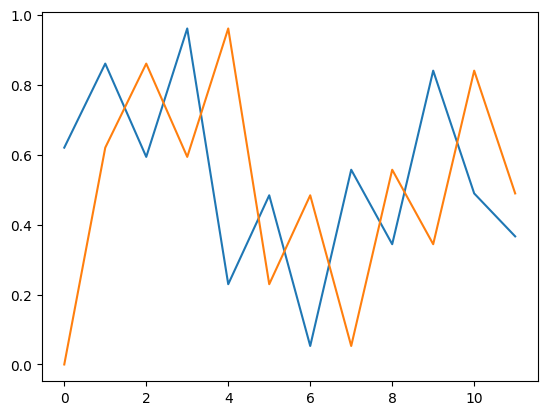

In [20]:
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [22]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = pd.DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = pd.concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df

In [23]:
supervised = timeseries_to_supervised(dataset, 1)
print(supervised.head())

          0         0
0  0.000000  0.062752
1  0.062752  0.908561
2  0.908561  0.255939
3  0.255939  0.671000
4  0.671000  0.325863


In [26]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [27]:

# invert differenced value
def inverse_difference(history, yhat, interval=1):
 return yhat + history[-interval]

In [28]:
differenced = difference(dataset, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(dataset, differenced[i], len(dataset)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0     [0.8458091]
1    [-0.6526222]
2     [0.4150605]
3    [-0.3451367]
4    [0.29852086]
dtype: object
0     [0.9085612]
1      [0.255939]
2     [0.6709995]
3    [0.32586282]
4     [0.6243837]
dtype: object


In [31]:
# transform scale
X = differenced.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

In [32]:
inverted_X = scaler.inverse_transform(scaled_X)

In [33]:
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

0    0.845809
1   -0.652622
2    0.415060
3   -0.345137
4    0.298521
dtype: float64


In [35]:
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

In [ ]:
layer = LSTM(4, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True)

In [ ]:
for i in range(1500):
    model.fit(X, 4, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

In [34]:

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [36]:
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [37]:
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=0.533882, Expected=0.619901
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=0.584692, Expected=0.860152
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=0.770611, Expected=0.593456
1/1 [==============================] - 0s 16ms/step
Month=4, Predicted=0.872931, Expected=0.960556
1/1 [==============================] - 0s 12ms/step
Month=5, Predicted=0.822775, Expected=0.229493
1/1 [==============================] - 0s 14ms/step
Month=6, Predicted=0.735550, Expected=0.483640
1/1 [==============================] - 0s 13ms/step
Month=7, Predicted=0.527405, Expected=0.052891
1/1 [==============================] - 0s 13ms/step
Month=8, Predicted=0.244512, Expected=0.556701
1/1 [==============================] - 0s 13ms/step
Month=9, Predicted=0.290932, Expected=0.343792
1/1 [==============================] - 0s 12ms/step
Month=10, Predicted=0.284419, Expected=0.839982
1/1 [====

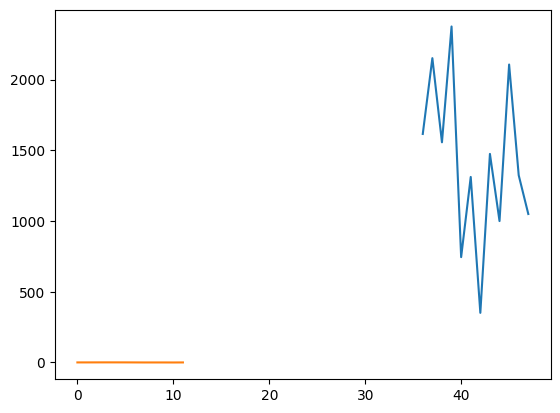

In [39]:
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
# raw_values = dataset.values
diff_values = difference(dataset, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # invert differencing
 yhat = inverse_difference(dataset, yhat, len(test_scaled)+1-i)
 # store forecast
 predictions.append(yhat)
 expected = dataset[len(train) + i + 1]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(dataset[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(dataframe[-12:])
pyplot.plot(predictions)
pyplot.show()
